# 环境变量

In [1]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/fileonssd/runway-dataset/lard-dataset
/home/yeli/workspace/lard/lard-detection


**this is to prove that why synthetic error increase**

# LARD相似度-分组

32 groups found


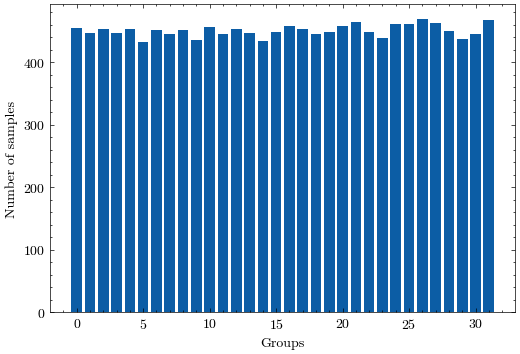

In [29]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

# 图片路径
path_images = f'{ROOT_PROJECT}/datasets/lard/detection/train_all/images'
all_path = glob.glob(f'{path_images}/*.jpeg')


# 使用字典来分组，键为文件名前7个字符，值为相应的文件路径列表
groups = {}
for path in all_path:
    key = os.path.basename(path)[:7]  # 提取文件名前7个字符作为键
    if key in groups:
        groups[key].append(path)
    else:
        groups[key] = [path]

# 打印结果或进行后续处理
print(f"{len(groups.keys())} groups found")
# for key, paths in groups.items():
#     print(f"Group '{key}': {len(paths)} files")

# 绘图
all_len_group = [len(v) for v in groups.values()]
plt.figure(figsize=(6,4))
plt.bar(x=np.arange(len(all_len_group)), height=all_len_group)
plt.xlabel('Groups')
plt.ylabel('Number of samples')
plt.show()

## SSIM矩阵计算

In [3]:
import cv2
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
from concurrent.futures import ThreadPoolExecutor, as_completed

def preload_images(new_groups):
    """预加载所有图像到内存中."""
    preloaded_images = {}
    for key, paths in tqdm(new_groups.items(), desc=f'Preloading images'):
        list_image = []
        for path in paths:
            img = cv2.imread(path)
            img_resized = cv2.resize(img, (640, 640))
            list_image.append(img_resized)
        preloaded_images[key] = list_image
    return preloaded_images

def compute_ssim(idx_pair, images_pair):
    """计算并返回两个图像之间的SSIM值和它们的索引对."""
    img1, img2 = images_pair
    ssim_value = ssim(img1, img2, multichannel=True, channel_axis=-1)
    return idx_pair, ssim_value

def sample_groups(groups, num_samples):
    """对groups的图像进行采样."""
    new_groups = {} 
    for key, paths in groups.items():
        if len(paths) > num_samples:
            new_groups[key] = random.sample(paths, num_samples)  # 随机选择new_num张
        else:
            new_groups[key] = paths  # 如果少于new_num张，就选择全部
    return new_groups

# 采样
num_samples = 20
sampled_groups = sample_groups(groups, num_samples)
        
# 预加载图像
preloaded_images = preload_images(sampled_groups)  # 预加载图像

# SSIM计算
for key, images in preloaded_images.items():

    # 创建一个n x n的SSIM矩阵
    n = len(images)
    ssim_matrix = np.zeros((n, n))

    # 使用线程池并行计算
    with ThreadPoolExecutor() as executor:

        # 创建一个映射future到索引对的字典
        future_to_idx = {}
        tasks = []

        # 提交任务
        for i in range(n):
            for j in range(i+1, n):
                future = executor.submit(compute_ssim, (i, j), (images[i], images[j]))
                future_to_idx[future] = (i, j)
                tasks.append(future)

        # 更新进度条
        for future in tqdm(as_completed(tasks), total=len(tasks), desc=f'Processing group {key}'):
            (i, j), ssim_value = future.result()
            ssim_matrix[i, j] = ssim_value
            ssim_matrix[j, i] = ssim_value  # 因为SSIM是对称的

    # 将主对角线设置为1
    np.fill_diagonal(ssim_matrix, 1)
    np.savetxt(f'{ROOT_PROJECT}/results/tables/ssim/lard_grouped/ssim_matrix_{key}.csv', ssim_matrix, delimiter=',', fmt='%f')


Processing group KMSY_2_: 100%|██████████| 190/190 [00:04<00:00, 43.71it/s]


## 热力图

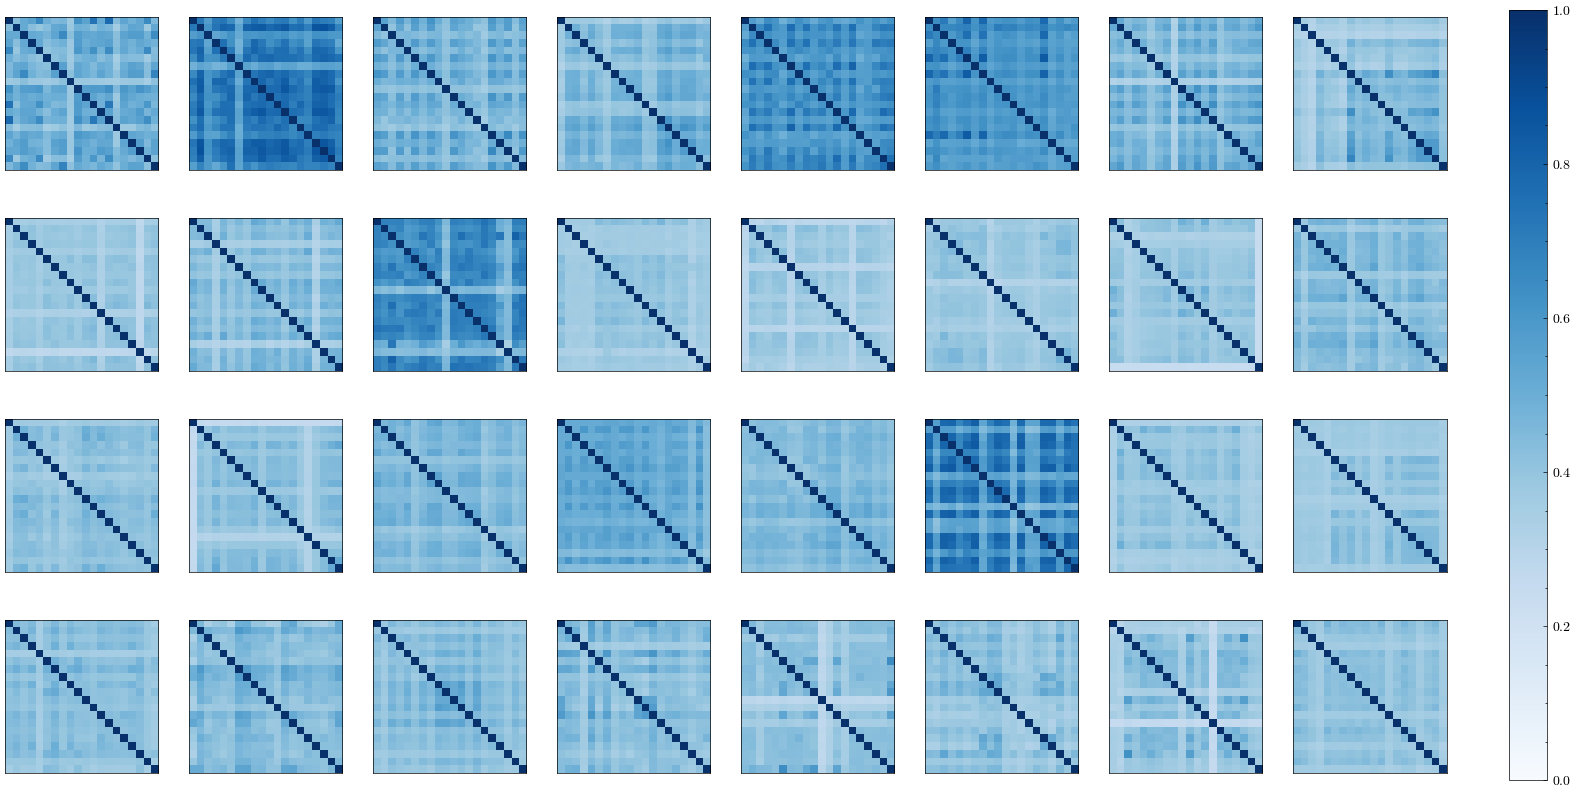

In [30]:
import glob
import numpy as np
import matplotlib.pyplot as plt

all_ssim_mean = []
fig, axs = plt.subplots(4, 8, figsize=(20, 10))

# 读取并处理每个SSIM矩阵CSV文件
all_csv = sorted(glob.glob(f'{ROOT_PROJECT}/results/tables/ssim/lard_grouped/ssim_*.csv'))
for idx, path_text in enumerate(all_csv):
    ssim_matrix = np.loadtxt(path_text, delimiter=',')
    
    # 计算当前SSIM矩阵的上三角均值并添加到列表
    mean_value = np.mean(np.triu(ssim_matrix, k=1)[np.triu(ssim_matrix, k=1) != 0])
    all_ssim_mean.append(mean_value)
    
    # 定位当前子图
    ax = axs[idx // 8, idx % 8]
    
    # 在当前子图上绘制热力图
    cax = ax.matshow(ssim_matrix, cmap='Blues', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
cbar = fig.colorbar(cax, ax=axs.ravel().tolist(), orientation='vertical', fraction=.03, pad=0.04)
cbar.ax.set_aspect(20)

plt.show()

## 均值分布

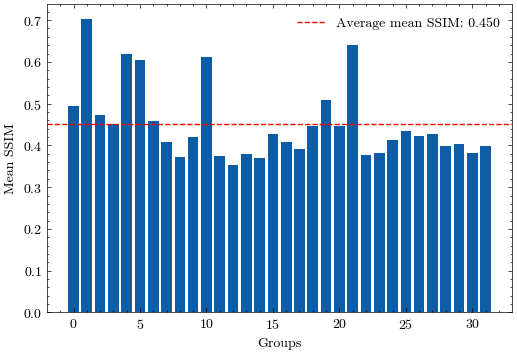

各组 [组内平均SSIM相似度] 的平均值:0.450


In [43]:
mean_ssim_lard_group = np.mean(all_ssim_mean)
plt.figure(figsize=(6,4))
plt.bar(x=np.arange(len(all_ssim_mean)), height=all_ssim_mean)
plt.axhline(y=mean_ssim_lard_group, color='r', linestyle='--', label=f'Average mean SSIM: {mean_ssim_lard_group:.3f}')
plt.xlabel('Groups')
plt.ylabel('Mean SSIM')
plt.legend()
plt.show()
print(f'各组 [组内平均SSIM相似度] 的平均值:{mean_ssim_lard_group:.3f}')

# SSIM = 1：表示两幅图像完全相同。
# SSIM > 0.75：通常可以认为图像具有较高的相似度，这意味着除了一些非常细微的差异外，两幅图像在视觉上非常接近。
# SSIM 在 0.5 到 0.75 之间：图像间具有一定的相似度，但存在一些明显的差异。
# SSIM < 0.5：通常表示图像相似度较低，差异较大。

# LARD相似度

In [33]:
import random
import glob
import cv2
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim


def compute_ssim(idx_pair, images_pair):
    """计算并返回两个图像之间的SSIM值和它们的索引对."""
    img1, img2 = images_pair
    ssim_value = ssim(img1, img2, multichannel=True, channel_axis=-1)
    return idx_pair, ssim_value

# 图片路径
path_images = f'{ROOT_PROJECT}/datasets/lard/detection/train_all/images'
all_path = glob.glob(f'{path_images}/*.jpeg')
num_samples = 200
all_path = random.sample(all_path, num_samples)

# 预加载
images = []
for path in tqdm(all_path, desc=f'Preloading images'):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (640, 640))
    images.append(img_resized)
    

Preloading images:   0%|          | 0/200 [00:00<?, ?it/s]

Preloading images: 100%|██████████| 200/200 [00:10<00:00, 18.58it/s]


## CPU计算

In [34]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# SSIM计算
# 创建一个n x n的SSIM矩阵
n = len(images)
ssim_matrix = np.zeros((n, n))

# 使用线程池并行计算
with ThreadPoolExecutor() as executor:

    # 创建一个映射future到索引对的字典
    future_to_idx = {}
    tasks = []

    # 提交任务
    for i in range(n):
        for j in range(i+1, n):
            future = executor.submit(compute_ssim, (i, j), (images[i], images[j]))
            future_to_idx[future] = (i, j)
            tasks.append(future)

    # 更新进度条
    for future in tqdm(as_completed(tasks), total=len(tasks), desc='Calculate SSIM'):
        (i, j), ssim_value = future.result()
        ssim_matrix[i, j] = ssim_value
        ssim_matrix[j, i] = ssim_value  # 因为SSIM是对称的

# 将主对角线设置为1
np.fill_diagonal(ssim_matrix, 1)
np.savetxt(f'{ROOT_PROJECT}/results/tables/ssim/lard/ssim_matrix_cpu.csv', ssim_matrix, delimiter=',', fmt='%f')

Calculate SSIM: 100%|██████████| 19900/19900 [11:38<00:00, 28.50it/s]


## CPU结果分析

In [35]:
import numpy as np

ssim_matrix_lard_cpu = np.loadtxt(f'{ROOT_PROJECT}/results/tables/ssim/lard/ssim_matrix_cpu.csv', delimiter=',')
mean_ssim_lard_cpu = np.mean(np.triu(ssim_matrix_lard_cpu, k=1)[np.triu(ssim_matrix_lard_cpu, k=1) != 0])
print(ssim_matrix_lard_cpu.shape)
print(f'{mean_ssim_lard_cpu:.3f}')

(200, 200)
0.420


## GPU计算

In [37]:
import numpy as np
import torch
from tqdm import tqdm
from pytorch_msssim import ssim

# 数据构造
X, Y = [], []
for i in range(n):
    for j in range(i+1, n):
        X.append(i)
        Y.append(j)

X = np.stack([images[i] for i in X], axis=0)
Y = np.stack([images[i] for i in Y], axis=0)
print(X.shape, Y.shape)

# 构造tensor变量
X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(Y).type(torch.float32)
print(X.shape, Y.shape)

# GPU加速计算
# ! pip install pytorch-msssim
batch_size = 256
ssim_vals = []

# 关闭梯度
with torch.no_grad():
    for i in tqdm(range(0, X.size(0), batch_size)):
        X_batch = X[i:i+batch_size].permute(0, 3, 1, 2).cuda()
        Y_batch = Y[i:i+batch_size].permute(0, 3, 1, 2).cuda()
        ssim_val_batch = ssim(X_batch, Y_batch, data_range=255, size_average=False)
        ssim_vals.append(ssim_val_batch.cpu())

ssim_vals = torch.cat(ssim_vals, dim=0)
ssim_vals = ssim_vals.detach().numpy()
np.savetxt(f'{ROOT_PROJECT}/results/tables/ssim/lard/ssim_matrix_gpu.csv', ssim_vals, delimiter=',', fmt='%f')

# 平均SSIM值
mean_ssim_lard_gpu = ssim_vals.mean()
print(f'{mean_ssim_lard_gpu:.3f}')

# 删除变量
del X_batch, Y_batch, X, Y, ssim_val_batch
torch.cuda.empty_cache()

(19900, 640, 640, 3) (19900, 640, 640, 3)
torch.Size([19900, 640, 640, 3]) torch.Size([19900, 640, 640, 3])


100%|██████████| 78/78 [00:49<00:00,  1.59it/s]


0.431


# COCO相似度

In [38]:
import random
import glob
import cv2
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from concurrent.futures import ThreadPoolExecutor, as_completed


def compute_ssim(idx_pair, images_pair):
    """计算并返回两个图像之间的SSIM值和它们的索引对."""
    img1, img2 = images_pair
    ssim_value = ssim(img1, img2, multichannel=True, channel_axis=-1)
    return idx_pair, ssim_value

# 图片路径
path_images = f'{ROOT_PROJECT}/datasets/coco/images/train2017'
all_path = glob.glob(f'{path_images}/*.jpg')
num_samples = 200
all_path = random.sample(all_path, num_samples)

# 预加载
images = []
for path in tqdm(all_path, desc=f'Preloading images'):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (640, 640))
    images.append(img_resized)


Preloading images: 100%|██████████| 200/200 [00:01<00:00, 117.31it/s]


## CPU计算

In [39]:
# SSIM计算
# 创建一个n x n的SSIM矩阵
n = len(images)
ssim_matrix = np.zeros((n, n))

# 使用线程池并行计算
with ThreadPoolExecutor() as executor:

    # 创建一个映射future到索引对的字典
    future_to_idx = {}
    tasks = []

    # 提交任务
    for i in range(n):
        for j in range(i+1, n):
            future = executor.submit(compute_ssim, (i, j), (images[i], images[j]))
            future_to_idx[future] = (i, j)
            tasks.append(future)

    # 更新进度条
    for future in tqdm(as_completed(tasks), total=len(tasks), desc='Calculate SSIM'):
        (i, j), ssim_value = future.result()
        ssim_matrix[i, j] = ssim_value
        ssim_matrix[j, i] = ssim_value  # 因为SSIM是对称的

# 将主对角线设置为1
np.fill_diagonal(ssim_matrix, 1)
np.savetxt(f'{ROOT_PROJECT}/results/tables/ssim/coco/ssim_matrix_cpu.csv', ssim_matrix, delimiter=',', fmt='%f')

Calculate SSIM: 100%|██████████| 19900/19900 [04:26<00:00, 74.57it/s] 


## CPU结果分析

In [41]:
import numpy as np

ssim_matrix_coco_cpu = np.loadtxt(f'{ROOT_PROJECT}/results/tables/ssim/coco/ssim_matrix_cpu.csv', delimiter=',')
mean_ssim_coco_cpu = np.mean(np.triu(ssim_matrix_coco_cpu, k=1)[np.triu(ssim_matrix_coco_cpu, k=1) != 0])
print(ssim_matrix_coco_cpu.shape)
print(f'{mean_ssim_coco_cpu:.3f}')

(200, 200)
0.193


## GPU计算

In [42]:
import numpy as np
import torch
from tqdm import tqdm
from pytorch_msssim import ssim

# 数据构造
X, Y = [], []
for i in range(n):
    for j in range(i+1, n):
        X.append(i)
        Y.append(j)

X = np.stack([images[i] for i in X], axis=0)
Y = np.stack([images[i] for i in Y], axis=0)
print(X.shape, Y.shape)

# 构造tensor变量
X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(Y).type(torch.float32)
print(X.shape, Y.shape)

# GPU加速计算
# ! pip install pytorch-msssim
batch_size = 256
ssim_vals = []

# 关闭梯度
with torch.no_grad():
    for i in tqdm(range(0, X.size(0), batch_size)):
        X_batch = X[i:i+batch_size].permute(0, 3, 1, 2).cuda()
        Y_batch = Y[i:i+batch_size].permute(0, 3, 1, 2).cuda()
        ssim_val_batch = ssim(X_batch, Y_batch, data_range=255, size_average=False)
        ssim_vals.append(ssim_val_batch.cpu())

ssim_vals = torch.cat(ssim_vals, dim=0)
ssim_vals = ssim_vals.detach().numpy()
np.savetxt(f'{ROOT_PROJECT}/results/tables/ssim/coco/ssim_matrix_gpu.csv', ssim_vals, delimiter=',', fmt='%f')

# 平均SSIM值
mean_ssim_coco_gpu = ssim_vals.mean()
print(f'{mean_ssim_coco_gpu:.3f}')

# 删除变量
del X_batch, Y_batch, X, Y, ssim_val_batch
torch.cuda.empty_cache()

(19900, 640, 640, 3) (19900, 640, 640, 3)
torch.Size([19900, 640, 640, 3]) torch.Size([19900, 640, 640, 3])


100%|██████████| 78/78 [00:48<00:00,  1.62it/s]


0.216


# 相似度对比

In [46]:
print(f'COCO mean SSIM CPU: {mean_ssim_coco_cpu:.3f}')
print(f'COCO mean SSIM GPU: {mean_ssim_coco_gpu:.3f}')

print(f'LARD mean SSIM CPU: {mean_ssim_lard_cpu:.3f}')
print(f'LARD mean SSIM GPU: {mean_ssim_lard_gpu:.3f}')
print(f'LARD mean SSIM group: {mean_ssim_lard_group:.3f}')

COCO mean SSIM CPU: 0.193
COCO mean SSIM GPU: 0.216
LARD mean SSIM CPU: 0.420
LARD mean SSIM GPU: 0.431
LARD mean SSIM group: 0.450
